<a href="https://colab.research.google.com/github/Jasper-Hewitt/final_project_elections/blob/main/ElectionSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub
!pip install opencc-python-reimplemented 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [2]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-roberta-wwm-ext"

if number_classes == 2:
    model_classifier = "Jiabo/Roberta_Chinese_sentiment"
else:
    model_classifier = "owen198/weibo-wmmbert-6"

In [3]:
model_classifier

'Jiabo/Roberta_Chinese_sentiment'

#1 黃珊珊

## 1.1 load and clean 黃珊珊 data

In [4]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_shanshan.xlsx

--2023-01-05 05:50:51--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_shanshan.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410939 (401K) [application/octet-stream]
Saving to: ‘scrap_shanshan.xlsx’

scrap_shanshan.xlsx 100%[===================>] 401.31K  --.-KB/s    in 0.04s   

2023-01-05 05:50:51 (10.9 MB/s) - ‘scrap_shanshan.xlsx’ saved [410939/410939]



In [5]:
import pandas as pd

In [6]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap_shanshan.xlsx')
testing_pd = testing_pd[['Timestamp','Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})
testing_pd

,Timestamp,text
0,2022-12-09T06:07:53.000Z,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n42m...
1,2022-12-09T05:06:22.000Z,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n1h對...
2,2022-12-08T23:45:48.000Z,Bruce Kuo\n@kuo1912\n·\n7hReplying to \n@i_don...
3,2022-12-08T04:13:23.000Z,肯尼不啃泥\n@i_dont_care_004\n·\n8 Dec喔我確定那個男的是白粉，因...
4,2022-12-07T14:52:24.000Z,ChenChen\n@Chen57962136\n·\n7 Dec[https://twit...
...,...,...
1683,2022-10-31T06:26:00.000Z,Need a Drink\n@KmtEnemy\n·\n31 Oct林洲民基本上是我最討厭的...
1684,2022-10-31T06:22:10.000Z,台灣推新聞\n@mytwnews\n·\n31 Oct嗆蔣萬安搞不清內湖科學園區狀況 黃珊珊...
1685,2022-10-31T06:18:41.000Z,逆轟高灰\n@IloveROCTW\n·\n31 OctReplying to \n@byj...
1686,2022-10-31T04:30:07.000Z,lemondemon\n@lemondemon\n·\n31 Oct轉噗 不來恩: 接到電話...


In [7]:
#convert to simplified
from opencc import OpenCC

# Create an OpenCC converter
cc = OpenCC('t2s')

# Define the conversion function
def convert_to_simplified(text):
    return cc.convert(text)

# Apply the conversion function to the "text" column
testing_pd["text"] = testing_pd["text"].apply(convert_to_simplified)

In [8]:
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'
#handle='^.*?·'
weirddot='·'


testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(handle,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(weirddot,'',regex=True)

In [9]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['Timestamp', 'text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,Timestamp,text
0,2022-12-09T06:07:53.000Z,台湾独立建国志愿军\n\n\n \n\n那陈时中可以去控告周玉蔻啊！\n他这时不告，什么...
1,2022-12-09T05:06:22.000Z,"台湾独立建国志愿军\n\n\n对手骂陈时中""谋财害命""，他不提告；\n对手抹黑陈时中和周玉..."
2,2022-12-08T23:45:48.000Z,\n\n\n \n\n黄珊珊也没结婚吧
3,2022-12-08T04:13:23.000Z,肯尼不啃泥\n\n\n 喔我确定那个男的是白粉，因为他就是在我面前对我说「我好希望是黄珊珊当...
4,2022-12-07T14:52:24.000Z,\n\n\n \n宅神说败而不溃\n黄珊珊及台湾民众党要快点有各种社群系统互动\n\n感想：...
...,...,...
1683,2022-10-31T06:26:00.000Z,\n\n\n 林洲民基本上是我最讨厌的人之一，但只要问对问题，不恶意攻击，我们不是都要认...
1684,2022-10-31T06:22:10.000Z,台湾推新闻\n\n\n 呛蒋万安搞不清内湖科学园区状况 黄珊珊：难怪政策常出笑话 - 自由时...
1685,2022-10-31T06:18:41.000Z,逆轰高灰\n\n\n \n\n之前黄珊珊在北市大办被轰，但是国中小办没问题，讲好就好，蒋...
1686,2022-10-31T04:30:07.000Z,\n\n\n 转噗 不来恩: 接到电话唯一支持黄珊珊~ ()\n\n \n.\n接到电话...


In [10]:
#store number of total posts
Huang_total_posts = len(testing_pd)

### 1.2.1 Tokenization

In [11]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [12]:
from transformers import AutoTokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [15]:
full_test_dataset = tokenized_datasets["test"]

## 1.2 preparing BERT


In [16]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

Downloading:   0%|          | 0.00/958 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [17]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-17-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [19]:
import numpy as np

## 1.3 prediction results


In [20]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Timestamp, text. If Timestamp, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1688
  Batch size = 8


In [21]:
pred

PredictionOutput(predictions=array([[ 3.43585   , -3.3553195 ],
       [ 1.4090855 , -1.862069  ],
       [ 1.800825  , -2.1092305 ],
       ...,
       [ 2.4620123 , -2.4719863 ],
       [-0.76062304,  0.93303615],
       [ 2.4344754 , -2.469761  ]], dtype=float32), label_ids=None, metrics={'test_runtime': 56.302, 'test_samples_per_second': 29.981, 'test_steps_per_second': 3.748})

In [22]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 0, 0, ..., 0, 1, 0])

In [23]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [24]:
#final table. Remember, 0 = negative, 1 = positive
Huang_pred_pd = testing_pd

In [25]:
Huang_pred_pd

,Timestamp,text,pred
0,2022-12-09T06:07:53.000Z,台湾独立建国志愿军\n\n\n \n\n那陈时中可以去控告周玉蔻啊！\n他这时不告，什么...,0
1,2022-12-09T05:06:22.000Z,"台湾独立建国志愿军\n\n\n对手骂陈时中""谋财害命""，他不提告；\n对手抹黑陈时中和周玉...",0
2,2022-12-08T23:45:48.000Z,\n\n\n \n\n黄珊珊也没结婚吧,0
3,2022-12-08T04:13:23.000Z,肯尼不啃泥\n\n\n 喔我确定那个男的是白粉，因为他就是在我面前对我说「我好希望是黄珊珊当...,0
4,2022-12-07T14:52:24.000Z,\n\n\n \n宅神说败而不溃\n黄珊珊及台湾民众党要快点有各种社群系统互动\n\n感想：...,1
...,...,...,...
1683,2022-10-31T06:26:00.000Z,\n\n\n 林洲民基本上是我最讨厌的人之一，但只要问对问题，不恶意攻击，我们不是都要认...,0
1684,2022-10-31T06:22:10.000Z,台湾推新闻\n\n\n 呛蒋万安搞不清内湖科学园区状况 黄珊珊：难怪政策常出笑话 - 自由时...,0
1685,2022-10-31T06:18:41.000Z,逆轰高灰\n\n\n \n\n之前黄珊珊在北市大办被轰，但是国中小办没问题，讲好就好，蒋...,0
1686,2022-10-31T04:30:07.000Z,\n\n\n 转噗 不来恩: 接到电话唯一支持黄珊珊~ ()\n\n \n.\n接到电话...,1


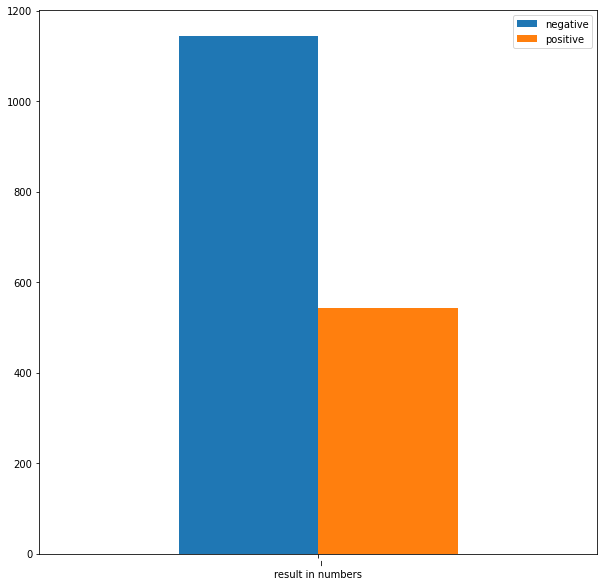

In [26]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
Huang_count0 = (Huang_pred_pd['pred'] == 0).sum()
Huang_count1 = (Huang_pred_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[Huang_count0], 'positive': [Huang_count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

##1.3.1 piechart

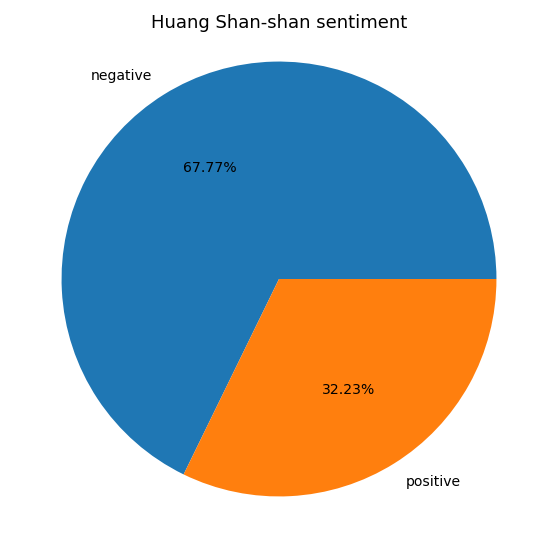

In [27]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

Huang_per1=Percentage(Huang_count0, Huang_count1)
Huang_per2=Percentage(Huang_count1, Huang_count0)

Huang_label = ['negative', 'positive']
Huang_shares = [Huang_per1, Huang_per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(Huang_shares, labels=Huang_label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Huang Shan-shan sentiment', fontsize=18, y=0.95);

##1.3.2 day by day overview Huang Shan-shan

In [28]:
Huang_pred_pd

,Timestamp,text,pred
0,2022-12-09T06:07:53.000Z,台湾独立建国志愿军\n\n\n \n\n那陈时中可以去控告周玉蔻啊！\n他这时不告，什么...,0
1,2022-12-09T05:06:22.000Z,"台湾独立建国志愿军\n\n\n对手骂陈时中""谋财害命""，他不提告；\n对手抹黑陈时中和周玉...",0
2,2022-12-08T23:45:48.000Z,\n\n\n \n\n黄珊珊也没结婚吧,0
3,2022-12-08T04:13:23.000Z,肯尼不啃泥\n\n\n 喔我确定那个男的是白粉，因为他就是在我面前对我说「我好希望是黄珊珊当...,0
4,2022-12-07T14:52:24.000Z,\n\n\n \n宅神说败而不溃\n黄珊珊及台湾民众党要快点有各种社群系统互动\n\n感想：...,1
...,...,...,...
1683,2022-10-31T06:26:00.000Z,\n\n\n 林洲民基本上是我最讨厌的人之一，但只要问对问题，不恶意攻击，我们不是都要认...,0
1684,2022-10-31T06:22:10.000Z,台湾推新闻\n\n\n 呛蒋万安搞不清内湖科学园区状况 黄珊珊：难怪政策常出笑话 - 自由时...,0
1685,2022-10-31T06:18:41.000Z,逆轰高灰\n\n\n \n\n之前黄珊珊在北市大办被轰，但是国中小办没问题，讲好就好，蒋...,0
1686,2022-10-31T04:30:07.000Z,\n\n\n 转噗 不来恩: 接到电话唯一支持黄珊珊~ ()\n\n \n.\n接到电话...,1


In [29]:
# Convert the 'date' column to datetime
Huang_pred_pd['Timestamp'] = pd.to_datetime(Huang_pred_pd['Timestamp'], format='%Y-%m-%d')

# Convert the datetime objects to normal date strings
Huang_pred_pd['Timestamp'] = Huang_pred_pd['Timestamp'].dt.strftime('%Y-%m-%d')

# Group the data by date and sentiment
grouped = Huang_pred_pd.groupby(['Timestamp', 'pred'])

# Count the number of rows in each group
counts = grouped.size().reset_index(name='count')

# Pivot the data so that each date has a separate row
pivoted = counts.pivot_table(index='Timestamp', columns='pred', values='count', fill_value=0)

#pivot the data so that each
pivoted = pivoted.rename(columns={0: "negative", 1: "positive"})

#create an extra column with the total number of posts
pivoted = pivoted.assign(total=pivoted["negative"] + pivoted["positive"])

# Define a function that calculates the percentage of negative from total
def calc_percentage(row):
    percentage = row["positive"] / row["total"]
    return percentage

# Add a new column called "percentage" to the dataframe
pivoted = pivoted.assign(percentage=pivoted.apply(calc_percentage, axis=1))

# Multiply all the values in the "percentage" column by 100
pivoted["percentage"] = pivoted["percentage"] * 100

pivoted

pred,negative,positive,total,percentage
Timestamp,,,,
2022-10-31,17,9,26,34.615385
2022-11-01,20,12,32,37.500000
2022-11-02,15,5,20,25.000000
2022-11-03,27,10,37,27.027027
2022-11-04,28,10,38,26.315789
2022-11-05,119,48,167,28.742515
2022-11-06,53,21,74,28.378378
2022-11-07,42,20,62,32.258065
2022-11-08,20,11,31,35.483871


Text(0.5, 1.0, 'Huang Shan-shan Over Time')

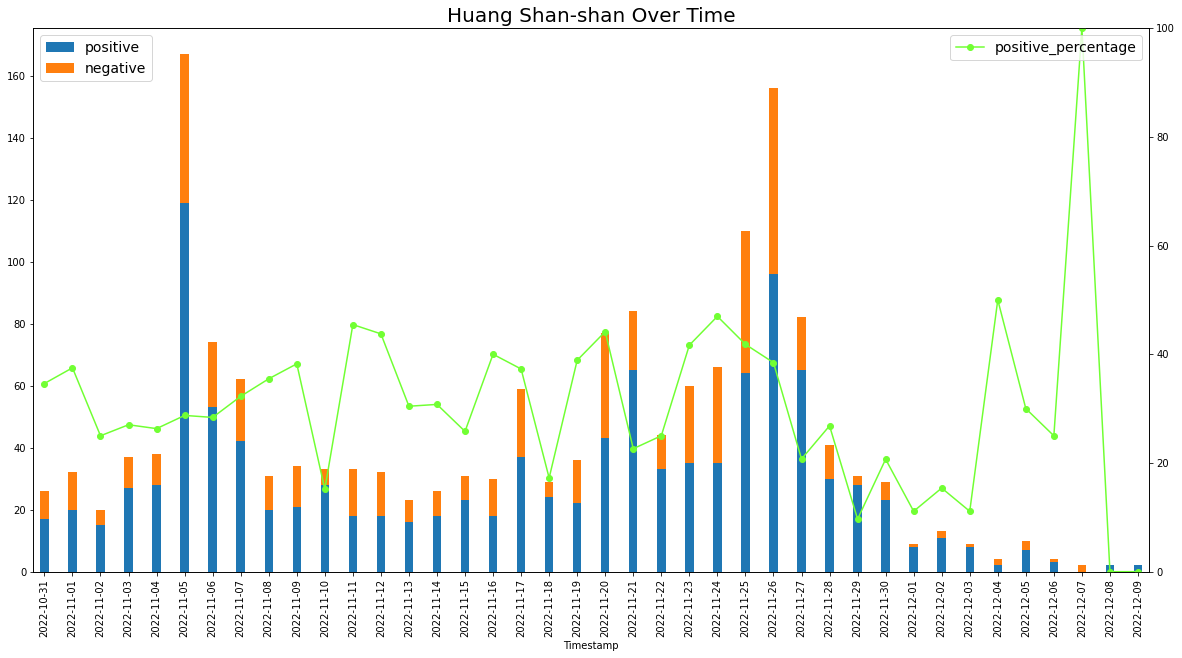

In [30]:
#old plot (without twin Y axis)

# # Create a figure and an axis
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot the data in a stacked bar chart
# pivoted[["negative", "positive"]].plot(kind="bar", stacked=True, ax=ax, width=0.3)

# # Plot the percentage data in a line chart
# pivoted["percentage"].plot(kind="line", ax=ax, color='#71FF33', marker="o")

# # Rotate the x-axis labels by 90 degrees
# plt.xticks(rotation=90)

# # Add the percentage line to the legend
# ax.legend(["positive_percentage", "positive", "negative"])

# plt.title("Huang Shan-shan Over Time", fontsize=20) 

# # Show the plot
# plt.show()

#____________________________________________________________________________________________

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the data in a stacked bar chart
pivoted[["negative", "positive"]].plot(kind="bar", stacked=True, ax=ax, width=0.3)

# Create a second y-axis
ax2 = ax.twinx()

# Set the range of the second y-axis to 0 to 100
ax2.set_ylim(0, 100)

# Plot the percentage data in a line chart on the second y-axis
pivoted["percentage"].plot(kind="line", ax=ax2, color='#71FF33', marker="o")

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add the percentage line to the legend
ax.legend(["positive", "negative"], loc="upper left", fontsize=14)
ax2.legend(["positive_percentage"], loc="upper right", fontsize=14)


plt.title("Huang Shan-shan Over Time", fontsize=20)

#2 蔣萬安

## 2.1 load and clean 蔣萬安 data

In [31]:
#insert new xlsx file here
! wget -nc https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/scraped_tweets/scrap_ChiangWanan.xlsx?raw=true

--2023-01-05 05:52:25--  https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/scraped_tweets/scrap_ChiangWanan.xlsx?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Jasper-Hewitt/final_project_elections/raw/main/data/scraped_tweets/scrap_ChiangWanan.xlsx [following]
--2023-01-05 05:52:26--  https://github.com/Jasper-Hewitt/final_project_elections/raw/main/data/scraped_tweets/scrap_ChiangWanan.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Jasper-Hewitt/final_project_elections/main/data/scraped_tweets/scrap_ChiangWanan.xlsx [following]
--2023-01-05 05:52:26--  https://raw.githubusercontent.com/Jasper-Hewitt/final_project_elections/main/data/scraped_tweets/scrap_ChiangWanan.xlsx
Resolving raw.githubusercontent.com (

In [32]:
import pandas as pd

In [33]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap_ChiangWanan.xlsx?raw=true')
testing_pd = testing_pd[['Timestamp','Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})
testing_pd

,Timestamp,text
0,2022-12-10T03:09:52.000Z,台灣推新聞\n@mytwnews\n·\n51m爆料北市府多人留任蔣萬安小內閣 柯大笑：代表...
1,2022-12-10T02:57:00.000Z,Lu Authority Philosophy\n@archer_taiwan\n·\n1h...
2,2022-12-10T02:49:02.000Z,鉅石會\n@GoldenRockTW\n·\n1h中共對台文攻武嚇，近年變本加厲備受國際關注...
3,2022-12-10T02:48:00.000Z,吳奕軍 JasonWu\n@jasonbosox\n·\n1h中共對台文攻武嚇，近年變本加厲...
4,2022-12-09T23:49:54.000Z,台灣大叔\n@XjxjjxDjdjdj\n·\n4hReplying to \n@Felix...
...,...,...
2750,2022-11-01T02:31:55.000Z,林揚傑在講話\n@findgfforlin\n·\n1 Nov 2022辛苦的公車司機下雨天...
2751,2022-11-01T02:04:01.000Z,大史瑞克\n@70135f5aec8f475\n·\n1 Nov 2022Replying ...
2752,2022-11-01T01:48:51.000Z,林天愛\n@jwXNlJCq7kTYRIz\n·\n1 Nov 2022Replying t...
2753,2022-11-01T01:04:23.000Z,peace抗中保台\n@GraceH73804547\n·\n1 Nov 2022蔣萬安說陳...


In [34]:
#convert to simplified
from opencc import OpenCC

# Create an OpenCC converter
cc = OpenCC('t2s')

# Define the conversion function
def convert_to_simplified(text):
    return cc.convert(text)

# Apply the conversion function to the "text" column
testing_pd["text"] = testing_pd["text"].apply(convert_to_simplified)

In [35]:
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'
#handle='^.*?·'
weirddot='·'


testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(handle,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(weirddot,'',regex=True)

In [36]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['Timestamp','text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,Timestamp,text
0,2022-12-10T03:09:52.000Z,台湾推新闻\n\n\n爆料北市府多人留任蒋万安小内阁 柯大笑：代表我的局处长太优秀 - 自由...
1,2022-12-10T02:57:00.000Z,\n\n\n蒋万安听清楚了！\n:\n
2,2022-12-10T02:49:02.000Z,巨石会\n\n\n中共对台文攻武吓，近年变本加厉备受国际关注，台湾人抗中保台是天经地义。\n...
3,2022-12-10T02:48:00.000Z,吴奕军 \n\n\n中共对台文攻武吓，近年变本加厉备受国际关注，台湾人抗中保台是天经地义。\...
4,2022-12-09T23:49:54.000Z,台湾大叔\n\n\n \n\n要检讨个人，趁现在还可以自由说话，快点大力检讨。\n以后共惨...
...,...,...
2750,2022-11-01T02:31:55.000Z,林扬杰在讲话\n\n\n 辛苦的公车司机下雨天还是在服务，希望柯文哲市长能帮他们嘉奖一下 ...
2751,2022-11-01T02:04:01.000Z,"大史瑞克\n\n\n \n\n \n\n只是让蒋万安卢小的工具少了一项而已,至于这个..."
2752,2022-11-01T01:48:51.000Z,林天爱\n\n\n \n\n当初蒋万安要政府全力支持\n现在某万安全力抹黑加靠北\n
2753,2022-11-01T01:04:23.000Z,抗中保台\n\n\n 蒋万安说陈时中要选台北市市长叫「染指」\n\n蒋公子大喊大叫「这是我...


In [37]:
#store number of total posts
Jiang_total_posts = len(testing_pd)

In [38]:
#store length


### 2.1.1 Tokenization

In [39]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [40]:
from transformers import AutoTokenizer

In [41]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--hfl--chinese-roberta-wwm-ext/snapshots/5c58d0b8ec1d9014354d691c538661bf00bfdb44/config.json
Model config BertConfig {
  "_name_or_path": "hfl/chinese-roberta-wwm-ext",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.

In [42]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [43]:
full_test_dataset = tokenized_datasets["test"]

## 2.2 preparing BERT for 蔣萬安


In [44]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Jiabo--Roberta_Chinese_sentiment/snapshots/4c1a2410151bc1f77e71f4cf7412283df355638c/config.json
Model config BertConfig {
  "_name_or_path": "Jiabo/Roberta_Chinese_sentiment",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem

In [45]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [46]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [47]:
import numpy as np

## 2.3 prediction results 蔣萬安


In [48]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Timestamp, text. If Timestamp, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2755
  Batch size = 8


In [49]:
pred

PredictionOutput(predictions=array([[-1.8731722 ,  2.1689029 ],
       [ 0.12960808, -0.52891433],
       [-1.4351956 ,  1.8177196 ],
       ...,
       [ 1.6646836 , -2.0038931 ],
       [ 2.7879105 , -2.666721  ],
       [ 1.1443735 , -1.6032383 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 92.0348, 'test_samples_per_second': 29.934, 'test_steps_per_second': 3.749})

In [50]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([1, 0, 1, ..., 0, 0, 0])

In [51]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [52]:
#final table. Remember, 0 = negative, 1 = positive
Chiang_pred_pd = testing_pd 

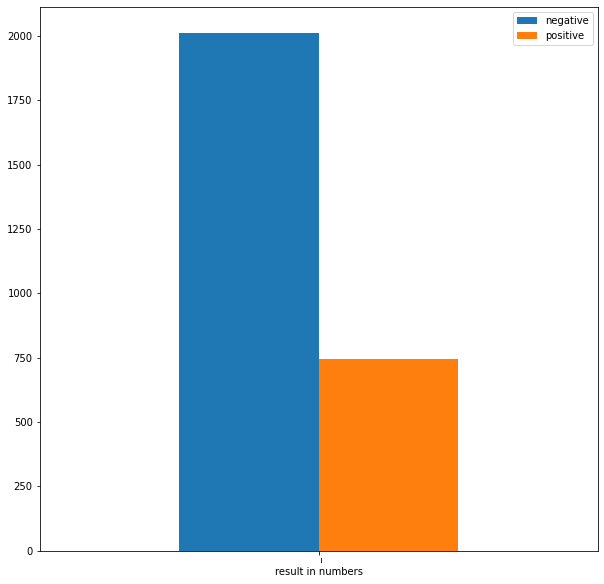

In [53]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
Chiang_count0 = (Chiang_pred_pd['pred'] == 0).sum()
Chiang_count1 = (Chiang_pred_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[Chiang_count0], 'positive': [Chiang_count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

##2.3.1 piechart

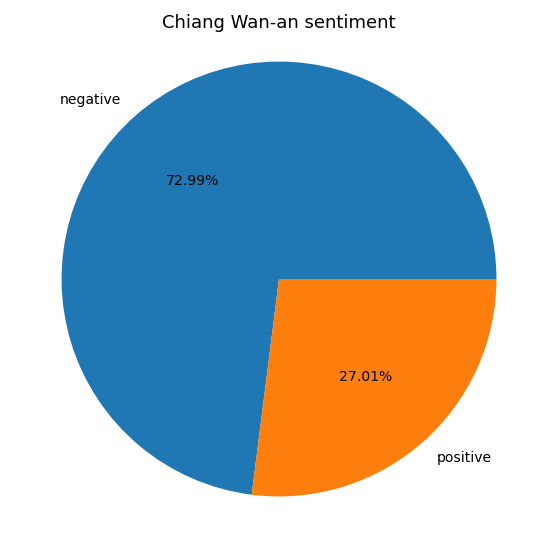

In [54]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

Chiang_per1=Percentage(Chiang_count0, Chiang_count1)
Chiang_per2=Percentage(Chiang_count1, Chiang_count0)

Chiang_label = ['negative', 'positive']
Chiang_shares = [Chiang_per1, Chiang_per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(Chiang_shares, labels=Chiang_label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Chiang Wan-an sentiment', fontsize=18, y=0.95);

##2.3.2 day by day overview Chiang Wan-an

In [55]:
Chiang_pred_pd

,Timestamp,text,pred
0,2022-12-10T03:09:52.000Z,台湾推新闻\n\n\n爆料北市府多人留任蒋万安小内阁 柯大笑：代表我的局处长太优秀 - 自由...,1
1,2022-12-10T02:57:00.000Z,\n\n\n蒋万安听清楚了！\n:\n,0
2,2022-12-10T02:49:02.000Z,巨石会\n\n\n中共对台文攻武吓，近年变本加厉备受国际关注，台湾人抗中保台是天经地义。\n...,1
3,2022-12-10T02:48:00.000Z,吴奕军 \n\n\n中共对台文攻武吓，近年变本加厉备受国际关注，台湾人抗中保台是天经地义。\...,1
4,2022-12-09T23:49:54.000Z,台湾大叔\n\n\n \n\n要检讨个人，趁现在还可以自由说话，快点大力检讨。\n以后共惨...,0
...,...,...,...
2750,2022-11-01T02:31:55.000Z,林扬杰在讲话\n\n\n 辛苦的公车司机下雨天还是在服务，希望柯文哲市长能帮他们嘉奖一下 ...,1
2751,2022-11-01T02:04:01.000Z,"大史瑞克\n\n\n \n\n \n\n只是让蒋万安卢小的工具少了一项而已,至于这个...",0
2752,2022-11-01T01:48:51.000Z,林天爱\n\n\n \n\n当初蒋万安要政府全力支持\n现在某万安全力抹黑加靠北\n,0
2753,2022-11-01T01:04:23.000Z,抗中保台\n\n\n 蒋万安说陈时中要选台北市市长叫「染指」\n\n蒋公子大喊大叫「这是我...,0


In [56]:
# Convert the 'date' column to datetime
Chiang_pred_pd['Timestamp'] = pd.to_datetime(Chiang_pred_pd['Timestamp'], format='%Y-%m-%d')

# Convert the datetime objects to normal date strings
Chiang_pred_pd['Timestamp'] = Chiang_pred_pd['Timestamp'].dt.strftime('%Y-%m-%d')

# Group the data by date and sentiment
grouped = Chiang_pred_pd.groupby(['Timestamp', 'pred'])

# Count the number of rows in each group
counts = grouped.size().reset_index(name='count')

# Pivot the data so that each date has a separate row
pivoted = counts.pivot_table(index='Timestamp', columns='pred', values='count', fill_value=0)

#pivot the data so that each
pivoted = pivoted.rename(columns={0: "negative", 1: "positive"})

#create an extra column with the total number of posts
pivoted = pivoted.assign(total=pivoted["negative"] + pivoted["positive"])

# Define a function that calculates the percentage of negative from total
def calc_percentage(row):
    percentage = row["positive"] / row["total"]
    return percentage

# Add a new column called "percentage" to the dataframe
pivoted = pivoted.assign(percentage=pivoted.apply(calc_percentage, axis=1))

# Multiply all the values in the "percentage" column by 100
pivoted["percentage"] = pivoted["percentage"] * 100

pivoted

pred,negative,positive,total,percentage
Timestamp,,,,
2022-11-01,48,4,52,7.692308
2022-11-02,44,4,48,8.333333
2022-11-03,59,8,67,11.940299
2022-11-04,23,9,32,28.125000
2022-11-05,203,50,253,19.762846
2022-11-06,76,33,109,30.275229
2022-11-07,75,11,86,12.790698
2022-11-08,54,9,63,14.285714
2022-11-09,65,20,85,23.529412


Text(0.5, 1.0, 'Chiang Wan-an Over Time')

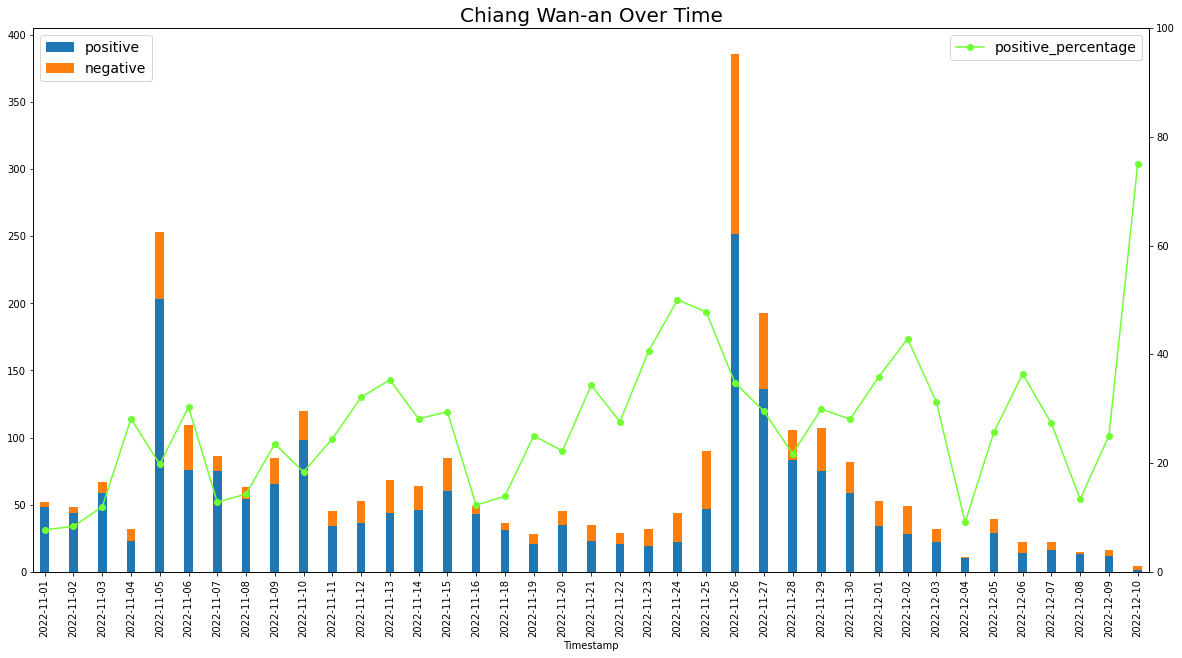

In [57]:
# old plot (without twin Y axis)

# # Create a figure and an axis
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot the data in a stacked bar chart
# pivoted[["negative", "positive"]].plot(kind="bar", stacked=True, ax=ax, width=0.3)

# # Plot the percentage data in a line chart
# pivoted["percentage"].plot(kind="line", ax=ax, color='#71FF33', marker="o")

# # Rotate the x-axis labels by 90 degrees
# plt.xticks(rotation=90)

# # Add the percentage line to the legend
# ax.legend(["positive_percentage", "positive", "negative"])

# plt.title("Chiang Wan-an Over Time", fontsize=20) 

# # Show the plot
# plt.show()

#____________________________________________________________________________________________

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the data in a stacked bar chart
pivoted[["negative", "positive"]].plot(kind="bar", stacked=True, ax=ax, width=0.3)

# Create a second y-axis
ax2 = ax.twinx()

# Set the range of the second y-axis to 0 to 100
ax2.set_ylim(0, 100)

# Plot the percentage data in a line chart on the second y-axis
pivoted["percentage"].plot(kind="line", ax=ax2, color='#71FF33', marker="o")

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add the percentage line to the legend
ax.legend(["positive", "negative"], loc="upper left", fontsize=14)
ax2.legend(["positive_percentage"], loc="upper right", fontsize=14)


plt.title("Chiang Wan-an Over Time", fontsize=20)

#3 陳時中

## 3.1 load and clean data

In [58]:
#insert new xlsx file here
! wget https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/scraped_tweets/Chen_complete.xlsx?raw=true

--2023-01-05 05:54:04--  https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/scraped_tweets/Chen_complete.xlsx?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Jasper-Hewitt/final_project_elections/raw/main/data/scraped_tweets/Chen_complete.xlsx [following]
--2023-01-05 05:54:04--  https://github.com/Jasper-Hewitt/final_project_elections/raw/main/data/scraped_tweets/Chen_complete.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Jasper-Hewitt/final_project_elections/main/data/scraped_tweets/Chen_complete.xlsx [following]
--2023-01-05 05:54:05--  https://raw.githubusercontent.com/Jasper-Hewitt/final_project_elections/main/data/scraped_tweets/Chen_complete.xlsx
Resolving raw.githubusercontent.com (raw.githubuserconten

In [59]:
import pandas as pd

In [60]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/Chen_complete.xlsx?raw=true')
testing_pd = testing_pd[['UserName', 'Timestamp','Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})
testing_pd

,UserName,Timestamp,text
0,FelixChang 台灣獨立建國志願軍,2022-12-10T03:04:48.000Z,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n11m...
1,Dshunter52 專職獵人,2022-12-10T02:39:16.000Z,Dshunter52 專職獵人\n@dshunter52\n·\n36mReplying t...
2,夜巡,2022-12-10T01:55:54.000Z,夜巡\n@aazz3738\n·\n1h陳時中初入江湖不求勝招卻想著求敗的境界\n太清高的人...
3,Romeolucian Popa,2022-12-10T01:40:30.000Z,Romeolucian Popa\n@RomeolucianP\n·\n1h吳怡農陳時中姚文...
4,Yang Hsun Cheng,2022-12-10T01:20:42.000Z,Yang Hsun Cheng\n@YShihjung\n·\n1h黑道教父黃承國，柯文哲蔡...
...,...,...,...
4852,黃凱莉KearyHuang,2022-11-01T05:21:14.000Z,黃凱莉KearyHuang\n@HuangKeary\n·\n1 Nov 2022自由廣場》...
4853,Gene Lewis Bavnabayev,2022-11-01T05:20:07.000Z,Gene Lewis Bavnabayev\n@bavnabayev\n·\n1 Nov 2...
4854,熊維尼,2022-11-01T05:15:30.000Z,熊維尼\n@xingwin3\n·\n1 Nov 2022Replying to \n@SX...
4855,相澤明和,2022-11-01T05:14:25.000Z,相澤明和\n@aizawaakito13\n·\n1 Nov 2022忘了為什麼想要遷移到新...


In [61]:
#convert to simplified
from opencc import OpenCC

# Create an OpenCC converter
cc = OpenCC('t2s')

# Define the conversion function
def convert_to_simplified(text):
    return cc.convert(text)

# Apply the conversion function to the "text" column
testing_pd["text"] = testing_pd["text"].apply(convert_to_simplified)

In [62]:
#delete all posts by 陳時中 himself. He is the only candidate who is active on Twitter: username = '陳時中 Chen Shih-Chung'

# create a boolean mask to select rows where the UserName column does not contain '陳時中 Chen Shih-Chung'
mask = testing_pd['UserName'] != '陳時中 Chen Shih-Chung'

# use the mask to select the rows to keep
testing_pd = testing_pd[mask]

In [63]:
#drop username column because we don't need it anymore
testing_pd = testing_pd.drop(columns=['UserName'], axis=1)

In [64]:
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'
#handle='^.*?·'
weirddot='·'


testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(handle,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(weirddot,'',regex=True)

In [65]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['Timestamp','text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,Timestamp,text
0,2022-12-10T03:04:48.000Z,"台湾独立建国志愿军\n\n\n陈时中败选后\n只扔下败选者的通用语""是我不够努力""\n就拍..."
1,2022-12-10T02:39:16.000Z,专职猎人\n\n\n \n\n所以你有把握如果陈时中每天去听早会，强力反击对手，堵麦时像...
2,2022-12-10T01:55:54.000Z,夜巡\n\n\n陈时中初入江湖不求胜招却想著求败的境界\n太清高的人真的不适合闯江湖(政治)...
3,2022-12-10T01:40:30.000Z,\n\n\n吴怡农陈时中姚文智三合一 绿大老叹蔡英文党末日膏肓 新闻大白话 \n\n...
4,2022-12-10T01:20:42.000Z,\n\n\n黑道教父黄承国，柯文哲蔡英文吕秀莲陈时中姚文智黄珊珊都倚重。影响台湾政治的黑...
...,...,...
4837,2022-11-01T05:21:14.000Z,黄凯莉\n\n\n 自由广场》我们没救回来的生命─写给陈时中\n...\n自由广场》我们没...
4838,2022-11-01T05:20:07.000Z,"\n\n\n \n\n, \n\n \n\n你还真信陈时中的话，剩余三千个空床，..."
4839,2022-11-01T05:15:30.000Z,"熊维尼\n\n\n \n\n, \n\n \n\n还是回答不出来喔？\n那你跟我说高..."
4840,2022-11-01T05:14:25.000Z,相泽明和\n\n\n 忘了为什么想要迁移到新西兰洲大陆？\n到底印度人民伊朗人民「（印度组...


In [66]:
#store number of total posts
Chen_total_posts = len(testing_pd)

### 3.1.2 Tokenization

In [67]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [68]:
from transformers import AutoTokenizer

In [69]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--hfl--chinese-roberta-wwm-ext/snapshots/5c58d0b8ec1d9014354d691c538661bf00bfdb44/config.json
Model config BertConfig {
  "_name_or_path": "hfl/chinese-roberta-wwm-ext",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.

In [70]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [71]:
full_test_dataset = tokenized_datasets["test"]

## 3.2 preparing BERT


In [72]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Jiabo--Roberta_Chinese_sentiment/snapshots/4c1a2410151bc1f77e71f4cf7412283df355638c/config.json
Model config BertConfig {
  "_name_or_path": "Jiabo/Roberta_Chinese_sentiment",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem

In [73]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [74]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [75]:
import numpy as np

##3.3 prediction results


In [76]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Timestamp, text. If Timestamp, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4842
  Batch size = 8


In [77]:
pred

PredictionOutput(predictions=array([[ 3.0594535, -2.981835 ],
       [ 1.5453585, -1.8427888],
       [ 2.5769672, -2.5496173],
       ...,
       [ 2.9699638, -2.898109 ],
       [ 1.7397519, -1.8646795],
       [ 1.7294322, -1.857864 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 162.6687, 'test_samples_per_second': 29.766, 'test_steps_per_second': 3.725})

In [78]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 0, 0, ..., 0, 0, 0])

In [79]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [80]:
#final table. Remember, 0 = negative, 1 = positive
Chen_pred_pd = testing_pd

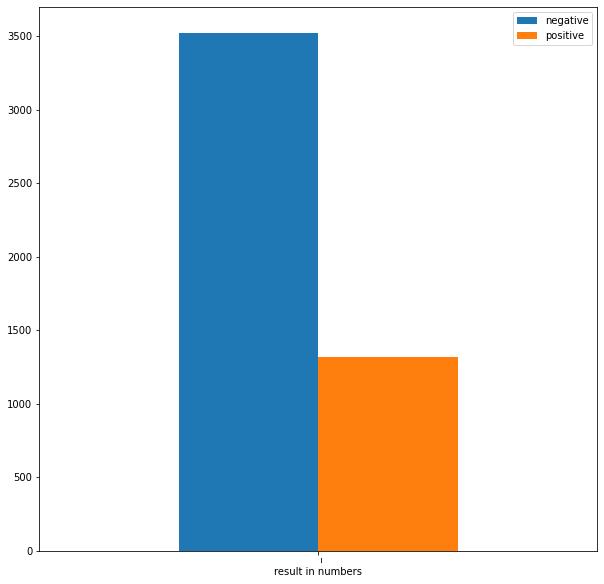

In [81]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
Chen_count0 = (Chen_pred_pd['pred'] == 0).sum()
Chen_count1 = (Chen_pred_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[Chen_count0], 'positive': [Chen_count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

##3.3.1 piechart

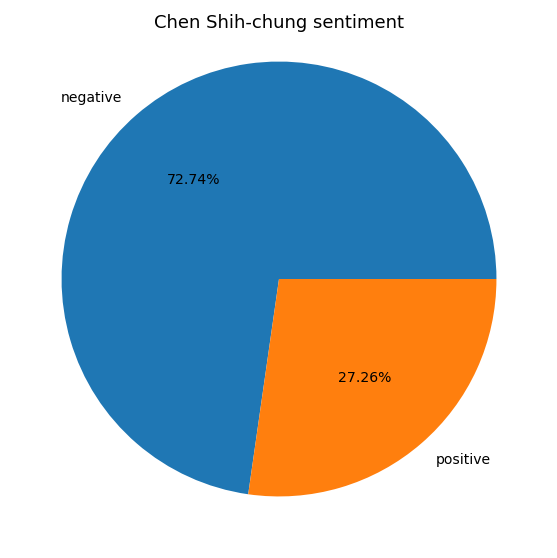

In [82]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

Chen_per1=Percentage(Chen_count0, Chen_count1)
Chen_per2=Percentage(Chen_count1, Chen_count0)

Chen_label = ['negative', 'positive']
Chen_shares = [Chen_per1, Chen_per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(Chen_shares, labels=Chen_label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Chen Shih-chung sentiment', fontsize=18, y=0.95);

##3.3.2 day by day overview Chen Shih-chung

In [83]:
Chen_pred_pd

,Timestamp,text,pred
0,2022-12-10T03:04:48.000Z,"台湾独立建国志愿军\n\n\n陈时中败选后\n只扔下败选者的通用语""是我不够努力""\n就拍...",0
1,2022-12-10T02:39:16.000Z,专职猎人\n\n\n \n\n所以你有把握如果陈时中每天去听早会，强力反击对手，堵麦时像...,0
2,2022-12-10T01:55:54.000Z,夜巡\n\n\n陈时中初入江湖不求胜招却想著求败的境界\n太清高的人真的不适合闯江湖(政治)...,0
3,2022-12-10T01:40:30.000Z,\n\n\n吴怡农陈时中姚文智三合一 绿大老叹蔡英文党末日膏肓 新闻大白话 \n\n...,0
4,2022-12-10T01:20:42.000Z,\n\n\n黑道教父黄承国，柯文哲蔡英文吕秀莲陈时中姚文智黄珊珊都倚重。影响台湾政治的黑...,1
...,...,...,...
4837,2022-11-01T05:21:14.000Z,黄凯莉\n\n\n 自由广场》我们没救回来的生命─写给陈时中\n...\n自由广场》我们没...,0
4838,2022-11-01T05:20:07.000Z,"\n\n\n \n\n, \n\n \n\n你还真信陈时中的话，剩余三千个空床，...",0
4839,2022-11-01T05:15:30.000Z,"熊维尼\n\n\n \n\n, \n\n \n\n还是回答不出来喔？\n那你跟我说高...",0
4840,2022-11-01T05:14:25.000Z,相泽明和\n\n\n 忘了为什么想要迁移到新西兰洲大陆？\n到底印度人民伊朗人民「（印度组...,0


In [84]:
# Convert the 'date' column to datetime
Chen_pred_pd['Timestamp'] = pd.to_datetime(Chen_pred_pd['Timestamp'], format='%Y-%m-%d')

# Convert the datetime objects to normal date strings
Chen_pred_pd['Timestamp'] = Chen_pred_pd['Timestamp'].dt.strftime('%Y-%m-%d')

# Group the data by date and sentiment
grouped = Chen_pred_pd.groupby(['Timestamp', 'pred'])

# Count the number of rows in each group
counts = grouped.size().reset_index(name='count')

# Pivot the data so that each date has a separate row
pivoted = counts.pivot_table(index='Timestamp', columns='pred', values='count', fill_value=0)

#pivot the data so that each
pivoted = pivoted.rename(columns={0: "negative", 1: "positive"})

#create an extra column with the total number of posts
pivoted = pivoted.assign(total=pivoted["negative"] + pivoted["positive"])

# Define a function that calculates the percentage of negative from total
def calc_percentage(row):
    percentage = row["positive"] / row["total"]
    return percentage

# Add a new column called "percentage" to the dataframe
pivoted = pivoted.assign(percentage=pivoted.apply(calc_percentage, axis=1))

# Multiply all the values in the "percentage" column by 100
pivoted["percentage"] = pivoted["percentage"] * 100

pivoted

pred,negative,positive,total,percentage
Timestamp,,,,
2022-11-01,55,19,74,25.675676
2022-11-02,82,19,101,18.811881
2022-11-03,73,30,103,29.126214
2022-11-04,83,11,94,11.702128
2022-11-05,248,94,342,27.485380
2022-11-06,110,55,165,33.333333
2022-11-07,278,72,350,20.571429
2022-11-08,122,41,163,25.153374
2022-11-09,89,37,126,29.365079


Text(0.5, 1.0, 'Chen Shih-chung Over Time')

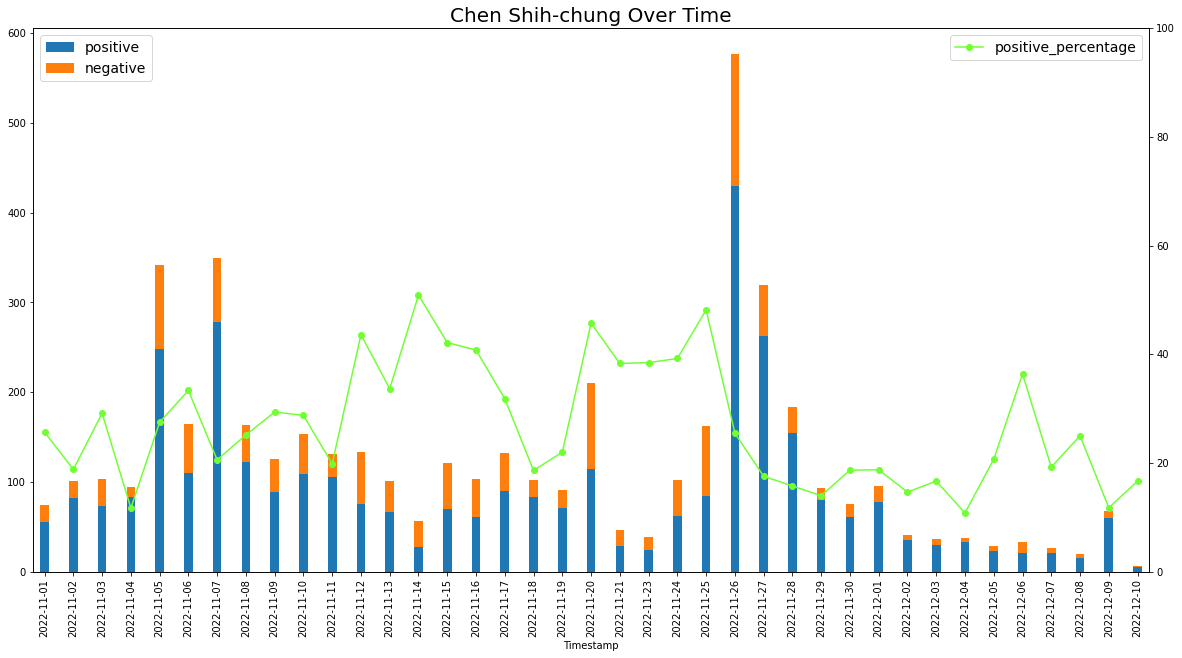

In [85]:
#old plot (without twin Y axis)

# # Create a figure and an axis
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot the data in a stacked bar chart
# pivoted[["negative", "positive"]].plot(kind="bar", stacked=True, ax=ax, width=0.3)

# # Plot the percentage data in a line chart
# pivoted["percentage"].plot(kind="line", ax=ax, color='#71FF33', marker="o")

# # Rotate the x-axis labels by 90 degrees
# plt.xticks(rotation=90)

# # Add the percentage line to the legend
# ax.legend(["positive_percentage", "positive", "negative"])

# # Add a title to the plot
# plt.title("Chen Shih-chung Over Time", fontsize=20)

# # Show the plot
# plt.show()

#____________________________________________________________________________________________

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the data in a stacked bar chart
pivoted[["negative", "positive"]].plot(kind="bar", stacked=True, ax=ax, width=0.3)

# Create a second y-axis
ax2 = ax.twinx()

# Set the range of the second y-axis to 0 to 100
ax2.set_ylim(0, 100)

# Plot the percentage data in a line chart on the second y-axis
pivoted["percentage"].plot(kind="line", ax=ax2, color='#71FF33', marker="o")

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add the percentage line to the legend
ax.legend(["positive", "negative"], loc="upper left", fontsize=14)
ax2.legend(["positive_percentage"], loc="upper right", fontsize=14)


plt.title("Chen Shih-chung Over Time", fontsize=20)

#5 comparison, comparison

In [86]:
data = [{'candidate': 'Chiang', 'total_posts': Jiang_total_posts},
        {'candidate': 'Chen', 'total_posts': Chen_total_posts},
        {'candidate': 'Huang', 'total_posts': Huang_total_posts}]

# Create the dataframe from the list of dictionaries
df_total = pd.DataFrame(data)

In [87]:
df_total

,candidate,total_posts
0,Chiang,2755
1,Chen,4842
2,Huang,1688


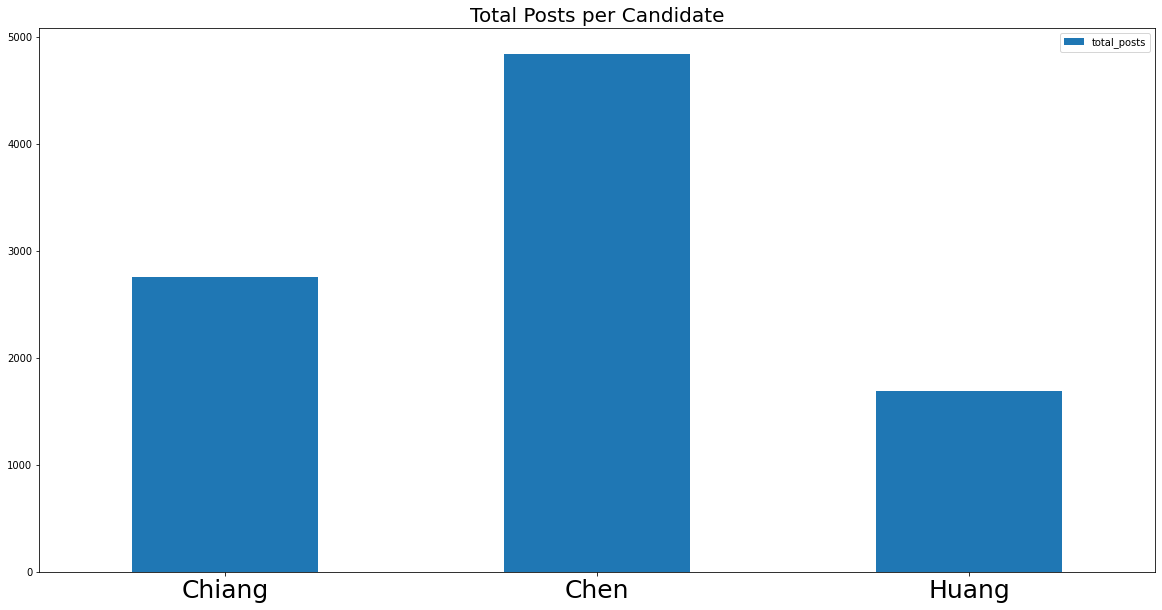

In [88]:
# Create the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot a bar plot of the data in the df dataframe
df_total.plot.bar(x='candidate', y='total_posts', ax=ax)

# Set the font size of the tick labels on the x-axis to 20 and rotate them to horizontal
ax.tick_params(axis='x', labelsize=25, rotation=0)

# Set the horizontal alignment of the tick labels to center
ax.set_xlabel('')
ax.xaxis.set_label_coords(0.5, -0.1)


# Add a title to the plot
ax.set_title('Total Posts per Candidate', fontsize=20)


plt.show()

# Show the plot
plt.show()

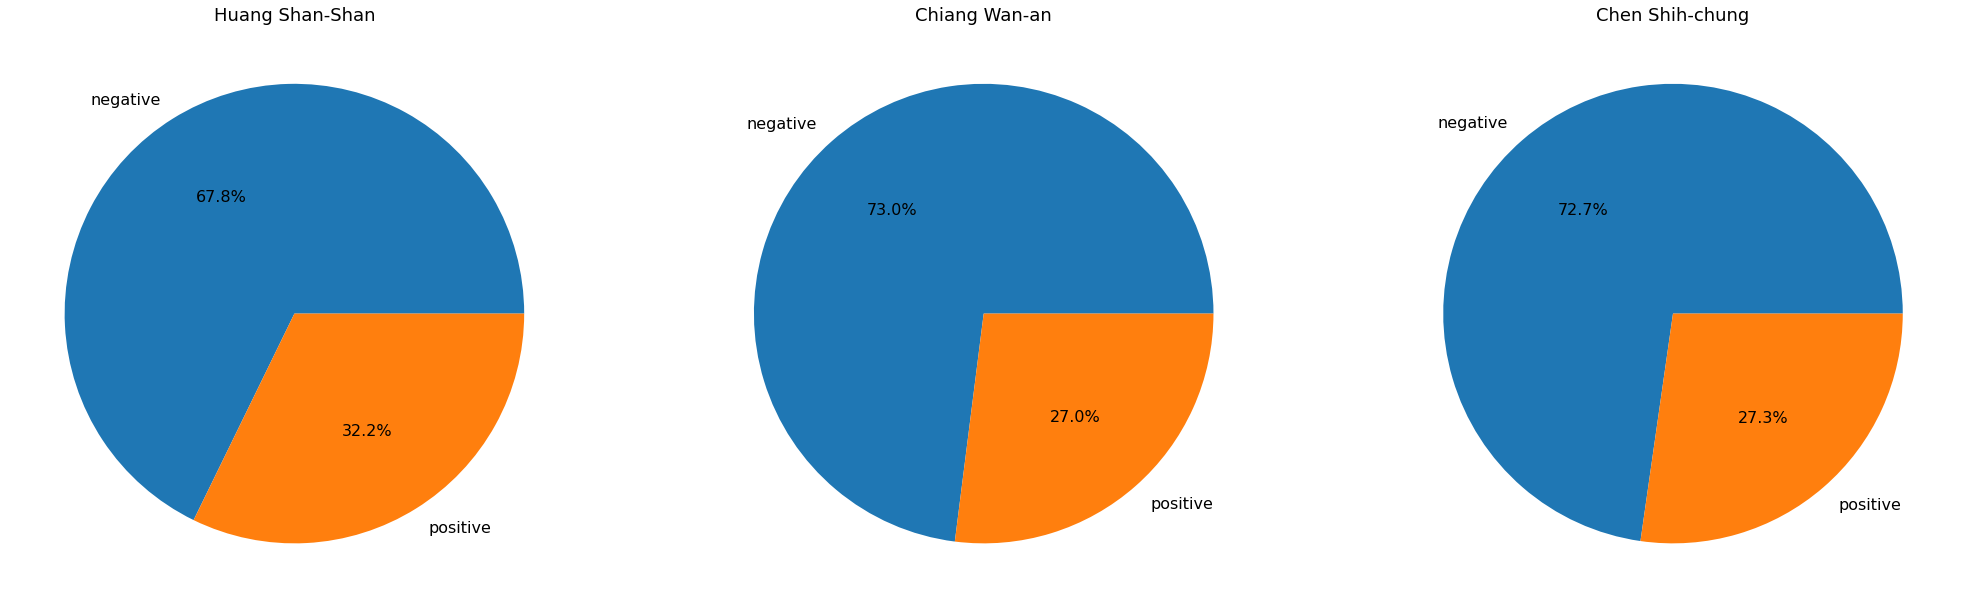

In [89]:
import matplotlib.pyplot as plt

# Create the figure and three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(35, 25))

# Plot the first pie chart
ax1.pie(Huang_shares, labels=Huang_label, autopct='%1.1f%%', textprops={'fontsize': 16})
ax1.set_title('Huang Shan-Shan', fontsize=18)

# Plot the second pie chart
ax2.pie(Chiang_shares, labels=Chiang_label, autopct='%1.1f%%', textprops={'fontsize': 16})
ax2.set_title('Chiang Wan-an', fontsize=18)

# Plot the third pie chart
ax3.pie(Chen_shares, labels=Chen_label, autopct='%1.1f%%', textprops={'fontsize': 16})
ax3.set_title('Chen Shih-chung', fontsize=18)

# Show the plot
plt.show()
